In [1]:
import keras
from keras.models import load_model
deepsea_model = load_model("/srv/scratch/avanti/ExPecto/resources/deepseabeluga_keras.h5")

Using TensorFlow backend.
W0824 15:26:56.079508 140447644239616 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 15:26:56.109214 140447644239616 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 15:26:56.173285 140447644239616 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 15:26:56.174242 140447644239616 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Pl

In [2]:
deepsea_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1993, 320)         10560     
_________________________________________________________________
activation_1 (Activation)    (None, 1993, 320)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1986, 320)         819520    
_________________________________________________________________
activation_2 (Activation)    (None, 1986, 320)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1986, 320)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 496, 320)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 489, 480)          1229280   
__________

In [3]:
from importlib import reload
import seqdataloader
from seqdataloader.batchproducers.coordbased.coordbatchproducers import SimpleCoordsBatchProducer
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals

positives_coords_batch_producer = SimpleCoordsBatchProducer(
    bed_file="2000bp_around_hg38_new_k562.narrowPeak.gz",
    batch_size=64)
negatives_coords_batch_producer = SimpleCoordsBatchProducer(
    bed_file="nok562_2000bp_around_hg38_merged_universal_neg_representative_peaks.bed.gz",
    batch_size=64)
coords_to_onehot = PyfaidxCoordsToVals(genome_fasta_path="hg38.fasta")

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


In [44]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle
def shuffle_several_times(s):
    assert len(s)==1 # one mode
    s = s[0]
    to_return = np.array([dinuc_shuffle(s) for i in range(20)])
    return to_return

#This combine_mult_and_diffref function can be used to generate hypothetical
# importance scores for one-hot encoded sequence.
#Hypothetical scores can be thought of as quick estimates of what the
# contribution *would have been* if a different base were present. Hypothetical
# scores are used as input to the importance score clustering algorithm
# TF-MoDISco (https://github.com/kundajelab/tfmodisco)
# Hypothetical importance scores are discussed more in this pull request:
#  https://github.com/kundajelab/deeplift/pull/36
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

dinuc_shuff_explainer = shap.DeepExplainer(
    #Importance is computed w.r.t. layers[-2] because that corresponds to the logit
    # of the sigmoid; we do this to avoid plateauing of importance scores due to
    # saturation of the sigmoid, as explained in the DeepLIFT paper
    #Task 61 because this is K562 as per
    # https://github.com/FunctionLab/ExPecto/blob/master/resources/deepsea_beluga_2002_features.tsv
    (deepsea_model.input, deepsea_model.layers[-2].output[:,61]),
    shuffle_several_times,
    #np.zeros((1,2000,4)),
    combine_mult_and_diffref=combine_mult_and_diffref)


In [52]:
import h5py
import numpy as np

!rm scores.h5
f = h5py.File("scores.h5")
f.create_dataset(
    "hyp_imp",
    (len(positives_coords_batch_producer.coords_list), 400,4),
    dtype="float32")
f.create_dataset(
    "seq",
    (len(positives_coords_batch_producer.coords_list), 400,4),
    dtype="float32")
f.create_dataset(
    "preds",
    (len(positives_coords_batch_producer.coords_list),),
    dtype="float32")

num_done = 0
for batch_idx in range(len(positives_coords_batch_producer)):
    print("Done",num_done)
    onehot = coords_to_onehot(positives_coords_batch_producer[batch_idx])
    f["seq"][num_done:num_done+len(onehot)] = onehot[:,800:1200]
    hyp_imp = dinuc_shuff_explainer.shap_values(onehot.astype("float32"))
    f["hyp_imp"][num_done:num_done+len(hyp_imp)] = hyp_imp[:,800:1200]
    f["preds"][num_done:num_done+len(hyp_imp)] =(
        deepsea_model.predict(onehot)[:,61])
    num_done += len(onehot)

Done 0
Done 64
Done 128
Done 192
Done 256
Done 320
Done 384
Done 448
Done 512
Done 576
Done 640
Done 704
Done 768
Done 832
Done 896
Done 960
Done 1024
Done 1088
Done 1152
Done 1216
Done 1280
Done 1344
Done 1408
Done 1472
Done 1536
Done 1600
Done 1664
Done 1728
Done 1792
Done 1856
Done 1920
Done 1984
Done 2048
Done 2112
Done 2176
Done 2240
Done 2304
Done 2368
Done 2432
Done 2496
Done 2560
Done 2624
Done 2688
Done 2752
Done 2816
Done 2880
Done 2944
Done 3008
Done 3072
Done 3136
Done 3200
Done 3264
Done 3328
Done 3392
Done 3456
Done 3520
Done 3584
Done 3648
Done 3712
Done 3776
Done 3840
Done 3904
Done 3968
Done 4032
Done 4096
Done 4160
Done 4224
Done 4288
Done 4352
Done 4416
Done 4480
Done 4544
Done 4608
Done 4672
Done 4736
Done 4800
Done 4864
Done 4928
Done 4992
Done 5056
Done 5120
Done 5184
Done 5248
Done 5312
Done 5376
Done 5440
Done 5504
Done 5568
Done 5632
Done 5696
Done 5760
Done 5824
Done 5888
Done 5952
Done 6016
Done 6080
Done 6144
Done 6208
Done 6272
Done 6336
Done 6400
Done 6464

Done 48960
Done 49024
Done 49088
Done 49152
Done 49216
Done 49280
Done 49344
Done 49408
Done 49472
Done 49536
Done 49600
Done 49664
Done 49728
Done 49792
Done 49856
Done 49920
Done 49984
Done 50048
Done 50112
Done 50176
Done 50240
Done 50304
Done 50368
Done 50432
Done 50496
Done 50560
Done 50624
Done 50688
Done 50752
Done 50816
Done 50880
Done 50944
Done 51008
Done 51072
Done 51136
Done 51200
Done 51264
Done 51328
Done 51392
Done 51456
Done 51520
Done 51584
Done 51648
Done 51712
Done 51776
Done 51840
Done 51904
Done 51968
Done 52032
Done 52096
Done 52160
Done 52224
Done 52288
Done 52352
Done 52416
Done 52480
Done 52544
Done 52608
Done 52672
Done 52736
Done 52800
Done 52864
Done 52928
Done 52992
Done 53056
Done 53120
Done 53184
Done 53248
Done 53312
Done 53376
Done 53440
Done 53504
Done 53568
Done 53632
Done 53696
Done 53760
Done 53824
Done 53888
Done 53952
Done 54016
Done 54080
Done 54144
Done 54208
Done 54272
Done 54336
Done 54400
Done 54464
Done 54528
Done 54592
Done 54656
Done 54720

Done 96640
Done 96704
Done 96768
Done 96832
Done 96896
Done 96960
Done 97024
Done 97088
Done 97152
Done 97216
Done 97280
Done 97344
Done 97408
Done 97472
Done 97536
Done 97600
Done 97664
Done 97728
Done 97792
Done 97856
Done 97920
Done 97984
Done 98048
Done 98112
Done 98176
Done 98240
Done 98304
Done 98368
Done 98432
Done 98496
Done 98560
Done 98624
Done 98688
Done 98752
Done 98816
Done 98880
Done 98944
Done 99008
Done 99072
Done 99136
Done 99200
Done 99264
Done 99328
Done 99392
Done 99456
Done 99520
Done 99584
Done 99648
Done 99712
Done 99776
Done 99840
Done 99904
Done 99968
Done 100032
Done 100096
Done 100160
Done 100224
Done 100288
Done 100352
Done 100416
Done 100480
Done 100544
Done 100608
Done 100672
Done 100736
Done 100800
Done 100864
Done 100928
Done 100992
Done 101056
Done 101120
Done 101184
Done 101248
Done 101312
Done 101376
Done 101440
Done 101504
Done 101568
Done 101632
Done 101696
Done 101760
Done 101824
Done 101888
Done 101952
Done 102016
Done 102080
Done 102144
Done 1022

Done 140672
Done 140736
Done 140800
Done 140864
Done 140928
Done 140992
Done 141056
Done 141120
Done 141184
Done 141248
Done 141312
Done 141376
Done 141440
Done 141504
Done 141568
Done 141632
Done 141696
Done 141760
Done 141824
Done 141888
Done 141952
Done 142016
Done 142080
Done 142144
Done 142208
Done 142272
Done 142336
Done 142400
Done 142464
Done 142528
Done 142592
Done 142656
Done 142720
Done 142784
Done 142848
Done 142912
Done 142976
Done 143040
Done 143104
Done 143168
Done 143232
Done 143296
Done 143360
Done 143424
Done 143488
Done 143552
Done 143616
Done 143680
Done 143744
Done 143808
Done 143872
Done 143936
Done 144000
Done 144064
Done 144128
Done 144192
Done 144256
Done 144320
Done 144384
Done 144448
Done 144512
Done 144576
Done 144640
Done 144704
Done 144768
Done 144832
Done 144896
Done 144960
Done 145024
Done 145088
Done 145152
Done 145216
Done 145280
Done 145344
Done 145408
Done 145472
Done 145536
Done 145600
Done 145664
Done 145728
Done 145792
Done 145856
Done 145920
Done

Done 184384
Done 184448
Done 184512
Done 184576
Done 184640
Done 184704
Done 184768
Done 184832
Done 184896
Done 184960
Done 185024
Done 185088
Done 185152
Done 185216
Done 185280
Done 185344
Done 185408
Done 185472
Done 185536
Done 185600
Done 185664
Done 185728
Done 185792
Done 185856
Done 185920
Done 185984
Done 186048
Done 186112
Done 186176
Done 186240
Done 186304
Done 186368
Done 186432
Done 186496
Done 186560
Done 186624
Done 186688
Done 186752
Done 186816
Done 186880
Done 186944
Done 187008
Done 187072
Done 187136
Done 187200
Done 187264
Done 187328
Done 187392
Done 187456
Done 187520
Done 187584
Done 187648
Done 187712
Done 187776
Done 187840
Done 187904
Done 187968
Done 188032
Done 188096
Done 188160
Done 188224
Done 188288
Done 188352
Done 188416
Done 188480
Done 188544
Done 188608
Done 188672
Done 188736
Done 188800
Done 188864
Done 188928
Done 188992
Done 189056
Done 189120
Done 189184
Done 189248
Done 189312
Done 189376
Done 189440
Done 189504
Done 189568
Done 189632
Done

In [31]:
deepsea_model.layers[-1].output

<tf.Tensor 'activation_8/Sigmoid:0' shape=(?, 2002) dtype=float32>

In [30]:
deepsea_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1993, 320)         10560     
_________________________________________________________________
activation_1 (Activation)    (None, 1993, 320)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1986, 320)         819520    
_________________________________________________________________
activation_2 (Activation)    (None, 1986, 320)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1986, 320)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 496, 320)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 489, 480)          1229280   
__________

In [53]:
f = h5py.File("scores.h5", mode="r")

In [54]:
f.keys()

<KeysViewHDF5 ['hyp_imp', 'preds', 'seq']>

In [55]:
f["hyp_imp"]

<HDF5 dataset "hyp_imp": shape (209865, 400, 4), type "<f4">

In [56]:
f["preds"]

<HDF5 dataset "preds": shape (209865,), type "<f4">

In [57]:
f["seq"]

<HDF5 dataset "seq": shape (209865, 400, 4), type "<f4">

In [58]:
f.close()

In [59]:
import numpy as np
f = h5py.File("scores.h5", mode="r")
preds = np.array(f["preds"][:])

In [60]:
sorted_indices = np.array([x[0] for x in 
                           sorted(enumerate(preds), key=lambda x: -x[1])])

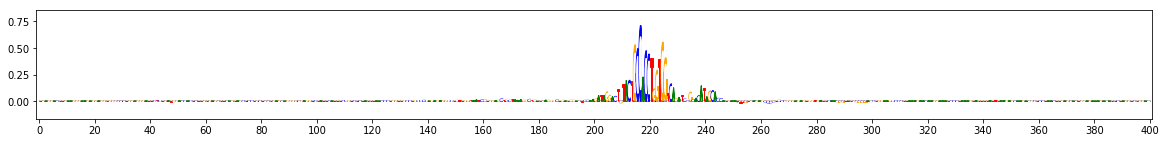

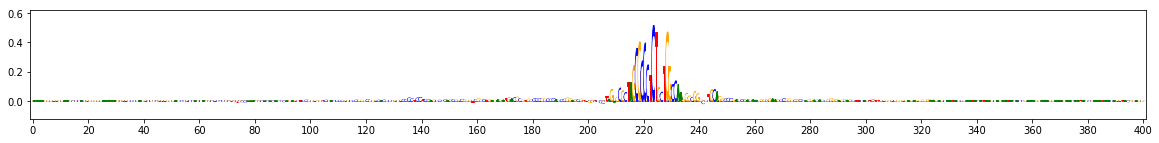

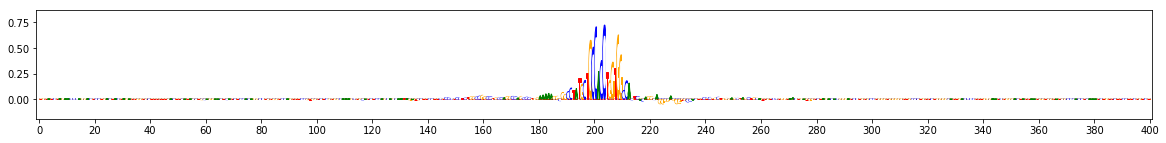

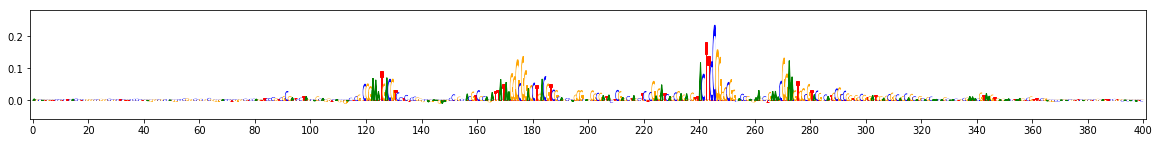

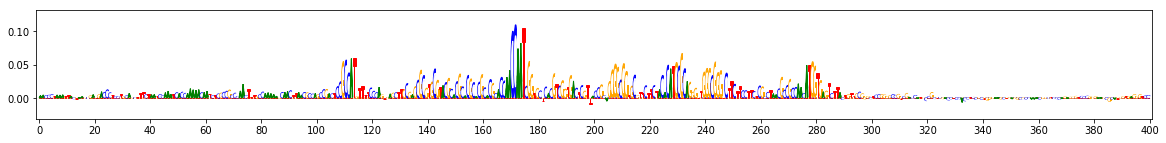

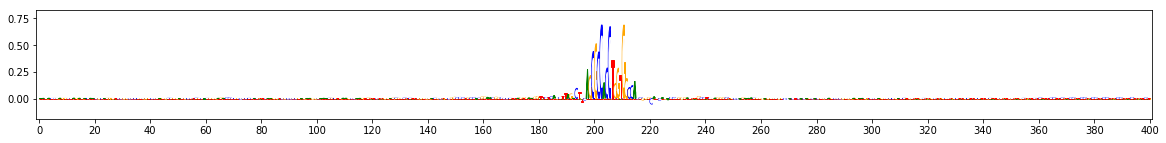

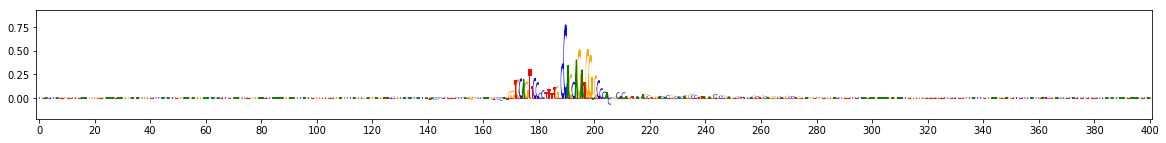

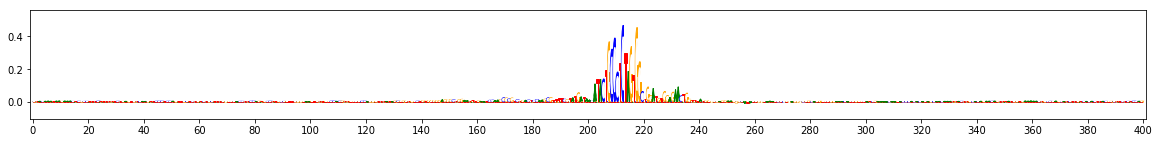

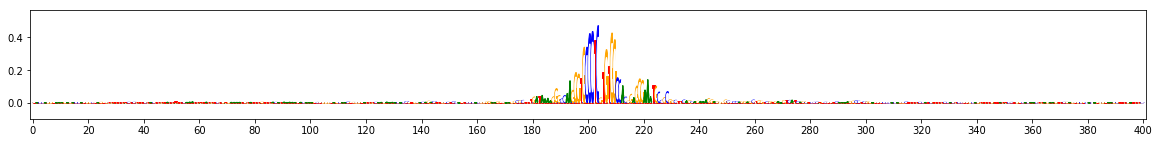

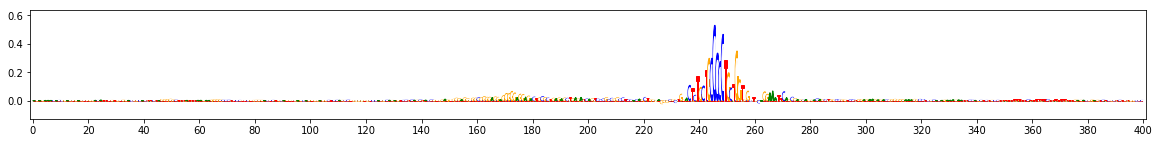

In [64]:
from modisco.visualization import viz_sequence

for idx in sorted_indices[:10]:
    viz_sequence.plot_weights((f["hyp_imp"][idx]*f["seq"][idx]),
                              subticks_frequency=20)

In [65]:
f.close()